In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0001
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = labels.shape[0]
ES_PATIENCE = 15
DECAY_DROP = 0.5
DECAY_EPOCHS = 10
classes = list(map(str, range(N_CLASSES)))

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score


def custom_f2(y_true, y_pred):
    beta = 2

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta**2)*p*r / (p*beta**2 + r + 1e-15)

    return f2

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = DECAY_DROP
    epochs_drop = DECAY_EPOCHS
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
Found 7443 images.


### Model

In [6]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.MobileNetV2(weights=None, include_top=False,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/mobilenet-v2-tf-kernels-96-no-top/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [7]:
# warm up model
# first: train only the top layers (which were randomly initialized)
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True
    
optimizer = optimizers.Adam(lr=LEARNING_RATE)
metrics = ["accuracy", "categorical_accuracy"]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=ES_PATIENCE)
callbacks = [es]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormal

#### Train top layers

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 519s - loss: 0.0367 - acc: 0.9898 - categorical_accuracy: 0.0433 - val_loss: 0.0246 - val_acc: 0.9971 - val_categorical_accuracy: 0.0482
Epoch 2/30
 - 503s - loss: 0.0169 - acc: 0.9970 - categorical_accuracy: 0.0814 - val_loss: 0.0191 - val_acc: 0.9971 - val_categorical_accuracy: 0.0686
Epoch 3/30
 - 504s - loss: 0.0152 - acc: 0.9971 - categorical_accuracy: 0.0913 - val_loss: 0.0161 - val_acc: 0.9971 - val_categorical_accuracy: 0.0648
Epoch 4/30
 - 498s - loss: 0.0143 - acc: 0.9971 - categorical_accuracy: 0.1027 - val_loss: 0.0146 - val_acc: 0.9971 - val_categorical_accuracy: 0.0869
Epoch 5/30
 - 498s - loss: 0.0137 - acc: 0.9972 - categorical_accuracy: 0.1076 - val_loss: 0.0142 - val_acc: 0.9971 - val_categorical_accuracy: 0.0792
Epoch 6/30
 - 506s - loss: 0.0134 - acc: 0.9972 - categorical_accuracy: 0.1086 - val_loss: 0.0143 - val_acc: 0.9970 - val_categorical_accuracy: 0.0826
Epoch 7/30
 - 494s - loss: 0.0129 - acc: 0.997

#### Fine-tune the complete model

In [9]:
for i in range(-16, 0):
    model.layers[i].trainable = True

metrics = ["accuracy", "categorical_accuracy"]
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=(ES_PATIENCE))
callbacks = [es, lrate]
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [10]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Epoch 1/30
 - 505s - loss: 0.0118 - acc: 0.9972 - categorical_accuracy: 0.1440 - val_loss: 0.0195 - val_acc: 0.9971 - val_categorical_accuracy: 0.1008
Epoch 2/30
 - 498s - loss: 0.0116 - acc: 0.9972 - categorical_accuracy: 0.1491 - val_loss: 0.0195 - val_acc: 0.9971 - val_categorical_accuracy: 0.1055
Epoch 3/30
 - 500s - loss: 0.0116 - acc: 0.9972 - categorical_accuracy: 0.1464 - val_loss: 0.0195 - val_acc: 0.9971 - val_categorical_accuracy: 0.1038
Epoch 4/30
 - 494s - loss: 0.0117 - acc: 0.9972 - categorical_accuracy: 0.1456 - val_loss: 0.0196 - val_acc: 0.9971 - val_categorical_accuracy: 0.1028
Epoch 5/30
 - 494s - loss: 0.0116 - acc: 0.9973 - categorical_accuracy: 0.1460 - val_loss: 0.0194 - val_acc: 0.9972 - val_categorical_accuracy: 0.1040
Epoch 6/30
 - 501s - loss: 0.0117 - acc: 0.9972 - categorical_accuracy: 0.1456 - val_loss: 0.0195 - val_acc: 0.9971 - val_categorical_accuracy: 0.1024
Epoch 7/30
 - 493s - loss: 0.0117 - acc: 0.9972 - categorical_accuracy: 0.1451 - val_loss: 0.0

### Complete model graph loss

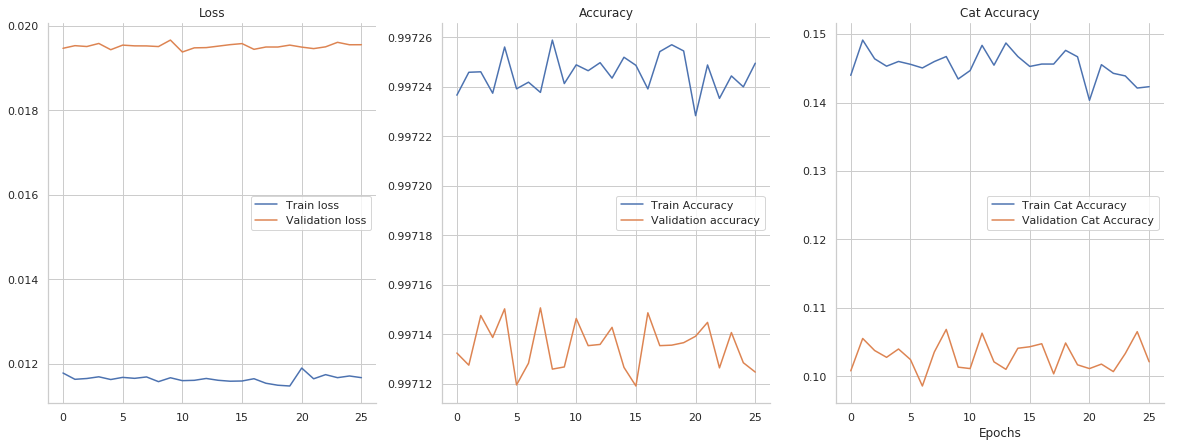

In [11]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [12]:
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
print(lastFullValPred.shape, lastFullValLabels.shape)

(27309, 1103) (27309, 1103)


thr=0.150 F2=0.273


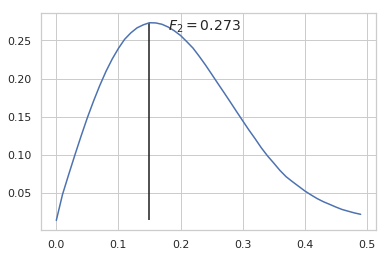

In [13]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in thrs:
        score.append(custom_f2(targs, (preds > thr).astype(int)))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

threshold, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

### Apply model to test set and output predictions

In [14]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [15]:
predictions = []
for pred_ar in preds:
    valid = []
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            valid.append(idx)
    if len(valid) == 0:
        valid.append(np.argmax(pred_ar))
    predictions.append(valid)

In [16]:
filenames = test_generator.filenames
label_map = {valid_generator.class_indices[k] : k for k in valid_generator.class_indices}

results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results['attribute_ids'] = results['attribute_ids'].apply(lambda x: list(map(label_map.get, x)))
results["attribute_ids"] = results["attribute_ids"].apply(lambda x: ' '.join(x))
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,1022 1059 121 147 217 433 51 559
1,100fbe75ed8fd887,1034 1039 1059 121 147 189 369 813 99
2,101b627524a04f19,121 147 433 497 498 813
3,10234480c41284c6,1034 1046 1092 121 13 147 189 194 335 51 671 7...
4,1023b0e2636dcea8,1059 1080 147 212 51 671 813
5,1039cd6cf85845c,1034 1046 1092 111 13 147 189 51 663 698 718 8...
6,103a5b3f83fbe88,1034 1092 147 189 51 813
7,10413aaae8d6a9a2,1034 1046 1092 121 13 147 189 194 335 433 483 ...
8,10423822b93a65ab,1034 1035 1059 121 13 147 189 51 671 79 813
9,1052bf702cb099f7,1046 1059 1092 147 156 189 335 477 51 655 671 ...
